**Progetto Machine Learning**
---
**Giovanni D'Agostino, Marco Giorgi**

Fase Preliminare: 
- individuare la GPU Tesla-P100
- montare il drive contenente il codice e i dataset

In [ ]:
########## Tipo GPU allocata #############
!nvidia-smi

Sun Dec 13 09:55:34 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
import sys
drive.mount('Project_ML')
sys.path.append('/content/Project_ML/My Drive/ML/ProveFinali/Dishwasher')

Mounted at Project_ML


# **Load Dataset**



Fase di Caricamento:
- import librerie
- load dei dataset main e dishwasher
- descrizione base dei dataset


In [ ]:
import preprocessing 
import pandas as pd
import model
import metrics
import generator
import stats_data
import tensorflow as tf
import numpy as np

In [ ]:
pd.set_option('float_format', '{:f}'.format)
df_main = pd.read_csv("/content/Project_ML/My Drive/ML/ProveFinali/main_train.csv")
df_main.describe(include='all')

,timestamp,power
count,6082508,6082508.000000
unique,6082508,nan
top,2019-03-03 21:13:54+01:00,nan
freq,1,nan
mean,NaN,370.915554
std,NaN,549.188099
min,NaN,73.481000
25%,NaN,167.012000
50%,NaN,236.648000
75%,NaN,356.898000


In [ ]:
df_dishwasher = pd.read_csv("/content/Project_ML/My Drive/ML/ProveFinali/dishwasher_train.csv")
df_dishwasher.describe(include='all')

,timestamp,power
count,6082508,6082508.000000
unique,6082508,nan
top,2019-03-03 21:13:54+01:00,nan
freq,1,nan
mean,NaN,25.871098
std,NaN,238.580181
min,NaN,0.000000
25%,NaN,0.000000
50%,NaN,0.000000
75%,NaN,0.000000


# **Train**

Fase di Train: 
- configurazione size window e batch
- preprocessing (load + padding + normalizzazione )
- configurazione generatore e addestramento
- salvataggio modello

In [ ]:
window_size= 999
batch_size = 512

In [ ]:
main_power = preprocessing.load_data(df_main)
dishwasher_power= preprocessing.load_data(df_dishwasher)
main_power_padded = preprocessing.padding(main_power, window_size) 
dishwasher_power_padded = preprocessing.padding(dishwasher_power, window_size)
min_Main = np.min(main_power)
max_Main = np.max(main_power)
min_Dish = np.min(dishwasher_power)
max_Dish = np.max(dishwasher_power)
main_power_nrm = preprocessing.normalizzazione(main_power_padded, min_Main, max_Main)
dishwasher_power_nrm = preprocessing.normalizzazione(dishwasher_power_padded, min_Dish, max_Dish)

In [ ]:
generator = generator.DataGenerator(main_power_nrm, dishwasher_power_nrm, window_len=window_size, batch_len=batch_size)

In [ ]:
model_dishwasher_tot = model.dishwasher_model(window_size)
fit_data_tot = model_dishwasher_tot.fit(x=generator, epochs=13, steps_per_epoch= generator.__len__())

Epoch 1/13
11880/11880 [==============================] - 339s 29ms/step - loss: 0.0225
Epoch 2/13
11880/11880 [==============================] - 340s 29ms/step - loss: 0.0052
Epoch 3/13
11880/11880 [==============================] - 340s 29ms/step - loss: 0.0050
Epoch 4/13
11880/11880 [==============================] - 339s 29ms/step - loss: 0.0049
Epoch 5/13
11880/11880 [==============================] - 343s 29ms/step - loss: 0.0048
Epoch 6/13
11880/11880 [==============================] - 339s 29ms/step - loss: 0.0048
Epoch 7/13
11880/11880 [==============================] - 340s 29ms/step - loss: 0.0048
Epoch 8/13
11880/11880 [==============================] - 340s 29ms/step - loss: 0.0048
Epoch 9/13
11880/11880 [==============================] - 340s 29ms/step - loss: 0.0048
Epoch 10/13
11880/11880 [==============================] - 339s 29ms/step - loss: 0.0048
Epoch 11/13
11880/11880 [==============================] - 340s 29ms/step - loss: 0.0048
Epoch 12/13
11880/11880 [=====

In [ ]:
####### Save model
model_dishwasher_tot.save('/content/Project_ML/My Drive/ML/ProveFinali/Dishwasher/modelloFinaleDishwasher')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/Project_ML/My Drive/ML/ProveFinali/Dishwasher/modelloFinaleDishwasher8/assets


# **Test**

Fase di Test:
- import librerie
- caricamento modello
- predict
- reverse normalizzazione
- calcolo F1
- plot grafici

In [ ]:
import generator
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (30,10)

In [ ]:
model_dishwasher_tot = tf.keras.models.load_model('/content/Project_ML/My Drive/ML/ProveFinali/Dishwasher/modelloFinaleDishwasher', custom_objects=None)

In [ ]:
data_generator = generator.DataGenerator(main_power_nrm, dishwasher_power_nrm, window_len=window_size, batch_len=batch_size, shuffle=False)
pred_dishwasher = model_dishwasher_tot.predict(x=data_generator, steps=data_generator.__len__(), verbose=1)

11880/11880 [==============================] - 119s 10ms/step


In [ ]:
####### F1
pred_dishwasher_reverse= preprocessing.reverse_norm(pred_dishwasher, min_Dish, max_Dish)
f1=metrics.f1_score( dishwasher_power, pred_dishwasher_reverse)
print("F1:",f1)

precision:  [0.9951916]
recall:  [0.994319]
F1: [0.9947551]


##**Plot**

In [ ]:
start_plot = 0   
end_plot = 6082508 # max 6082508

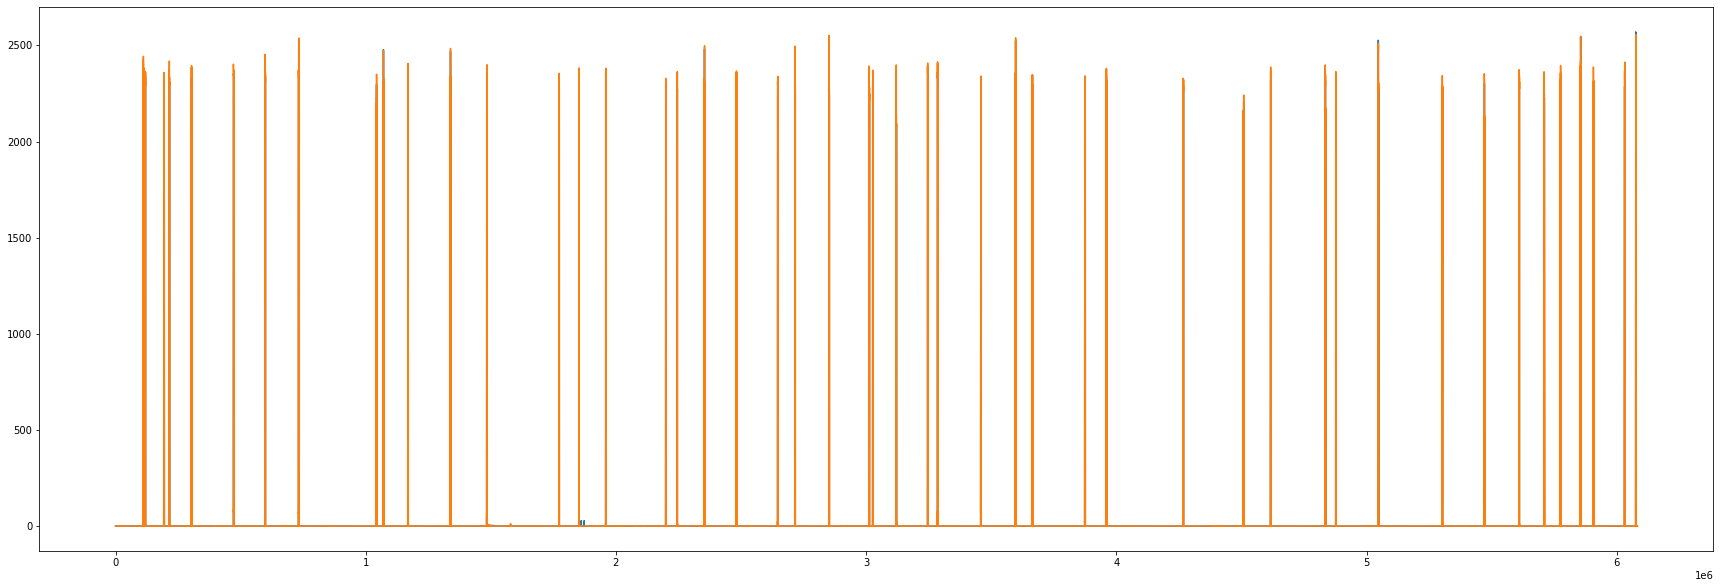

In [ ]:
dishwasher_power_plot=np.array(dishwasher_power).reshape(-1,1)
plt.plot(dishwasher_power_plot[start_plot:end_plot])
plt.plot(pred_dishwasher_reverse[start_plot:end_plot])